In [2]:
import time

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# learning
from sklearn.linear_model import LogisticRegression

# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [5]:
# description
description = pd.read_csv('data/WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('data/training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization'.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [6]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['immunosuppression']

{'Category': 'APACHE comorbidity',
 'Unit of Measure': 'None',
 'Data Type': 'binary',
 'Description': 'Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).',
 'Example': '1'}

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [4]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus valsplit
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [6]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

c:\Users\20200642\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer', SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D514B97C10>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D514B98550>)])

Time: 4.82s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


In [11]:
percent_missing = X_train.isnull().sum() * 100 / len(X_train)
missing_value_df = pd.DataFrame({'column_name': X_train.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

missing_value_df

,column_name,percent_missing
num__age,num__age,0.0
num__h1_potassium_min,num__h1_potassium_min,0.0
num__h1_sodium_max,num__h1_sodium_max,0.0
num__h1_sodium_min,num__h1_sodium_min,0.0
num__d1_arterial_pco2_max,num__d1_arterial_pco2_max,0.0
...,...,...
num__h1_heartrate_max,num__h1_heartrate_max,0.0
num__h1_heartrate_min,num__h1_heartrate_min,0.0
num__h1_mbp_max,num__h1_mbp_max,0.0
num__d1_sysbp_noninvasive_min,num__d1_sysbp_noninvasive_min,0.0


In [10]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

missing_value_df

,column_name,percent_missing
encounter_id,encounter_id,0.000000
pre_icu_los_days,pre_icu_los_days,0.000000
icu_type,icu_type,0.000000
icu_stay_type,icu_stay_type,0.000000
icu_id,icu_id,0.000000
...,...,...
h1_albumin_min,h1_albumin_min,91.398166
h1_lactate_min,h1_lactate_min,91.992411
h1_lactate_max,h1_lactate_max,91.992411
h1_bilirubin_max,h1_bilirubin_max,92.265001


In [7]:
X_train

,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__weight,num__albumin_apache,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,...,cat__apache_3j_bodysystem_Genitourinary,cat__apache_3j_bodysystem_Gynecological,cat__apache_3j_bodysystem_Hematological,cat__apache_3j_bodysystem_Metabolic,cat__apache_3j_bodysystem_Musculoskeletal/Skin,cat__apache_3j_bodysystem_Neurological,cat__apache_3j_bodysystem_Respiratory,cat__apache_3j_bodysystem_Sepsis,cat__apache_3j_bodysystem_Trauma,cat__apache_3j_bodysystem_nan
0,86.000000,28.168975,0.0,170.2,0.000000,81.6,2.90288,301.00000,408.020000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,72.000000,36.635088,0.0,170.1,0.088889,106.0,2.90288,124.00000,305.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36.000000,27.459684,0.0,162.6,0.044444,72.6,2.90288,122.00000,703.030000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60.000000,21.977351,0.0,181.0,0.213194,72.0,2.90288,305.00000,901.030000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.000000,19.960244,0.0,177.8,0.052083,63.1,2.50000,113.00000,501.040000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,16.000000,22.378743,1.0,165.1,0.004167,61.0,2.90288,219.00000,1504.040000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
73366,70.000000,29.475309,1.0,180.0,0.560417,95.5,2.90288,185.43556,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73367,72.000000,30.827304,1.0,187.0,0.236806,107.8,2.90288,202.00000,1205.010000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73368,46.000000,61.339079,0.0,167.6,0.000000,172.3,3.40000,102.00000,206.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [9]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 26.46s


c:\Users\20200642\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


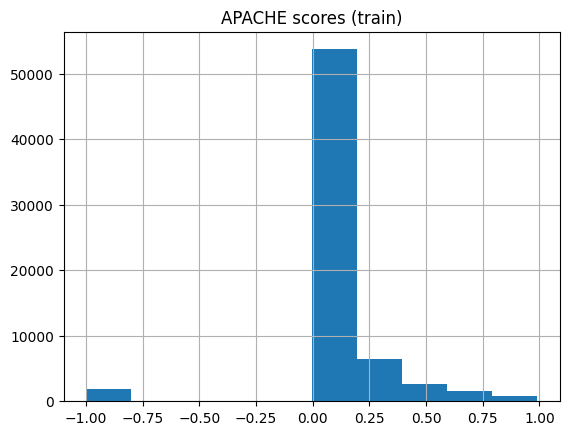

In [10]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()